In [ ]:
# Optional: setup NoTexBook theme
%load_ext notexbook
%texify -fs 18

**Adapted from**: [Ch2](https://github.com/uvm-plaid/programming-dp/blob/master/notebooks/ch2.ipynb)

# $k$-Anonymity

$k$-Anonymity[2](#fn2) is a *formal privacy definition*. 

The definition of $k$-Anonymity is designed to formalize our intuition that a piece of auxiliary information should not narrow down the set of possible records for an individual "too much." 

In other terms, $k$-Anonymity is designed to ensure that each individual can _blend into the crowd._

Informally, we say that a dataset is "$k$-Anonymized" for a particular $k$ if each individual in the dataset is a member of a group of size at least $k$, such that each member of the group shares the same *quasi-identifiers* (a selected subset of all the dataset's columns) with all other members of the group. 

Therefore, the individuals in each group "blend into" their group - it's possible to narrow down an individual to membership in a particular group, but not to determine which group member is the target.

> **Definition** (more formally) A dataset $D$ satisfies $k$-Anonymity for a value of $k$ if:
> 
> - For each row $r_1 \in D$, there exist at least $k-1$ other rows $r_2 \dots r_k \in D$ such that 
> $\Pi_{qi(D)} r_1 = \Pi_{qi(D)} r_2, \ldots, = \Pi_{qi(D)} r_k$
>
> where $qi(D)$ is the quasi-identifiers of $D$, and $\Pi_{qi(D)} r$ represents the columns of $r$ containing quasi-identifiers (i.e. the projection of the quasi-identifiers).

<span id="fn1">**[2]**: Sweeney, L: _k-ANONYMITY: A MODEL FOR PROTECTING PRIVACY_ on International Journal of Uncertainty, Fuzziness and Knowledge-Based Systems, 2002 [link](https://doi.org/10.1142/S0218488502001648)</span>

>**Learning Objectives**
After reading this chapter, you will understand:
> - The definition of $k$-Anonymity
> - How to check for $k$-Anonymity
> - How to generalize data to enforce $k$-Anonymity
> - The limitations of $k$-Anonymity

## Checking for $k$-Anonymity

We'll start with a small dataset, so that we can immediately see by looking at the data whether it satisfies $k$-Anonymity or not. 

This dataset contains age plus two test scores; it clearly doesn't satisfy $k$-Anonymity for $k > 1$. 

Any dataset trivially satisfies $k$-Anonymity for $k = 1$, since each row can form its own group of size 1.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [4]:
example_data = {
    'first_name': ['Jason', 'Molly', 'Tina', 'Jake', 'Amy'], 
    'last_name': ['Miller', 'Jacobson', 'Ali', 'Milner', 'Cooze'], 
    'age': [42, 52, 36, 24, 73], 
    'preTestScore': [4, 24, 31, 2, 3],
    'postTestScore': [25, 94, 57, 62, 70]}
df = pd.DataFrame(example_data, columns = ['first_name', 'last_name', 'age', 'preTestScore', 'postTestScore'])
df

,first_name,last_name,age,preTestScore,postTestScore
0,Jason,Miller,42,4,25
1,Molly,Jacobson,52,24,94
2,Tina,Ali,36,31,57
3,Jake,Milner,24,2,62
4,Amy,Cooze,73,3,70


To implement a function to check whether a dataframe satisfies $k$-Anonymity, we loop over the rows. 

For each row, we query the dataframe to see how many rows match its values for the quasi-identifiers. 

If the number of rows in any group is less than $k$, the dataframe **does not** satisfy $k$-Anonymity for that value of $k$, and we return `False`. 

Note that in this simple definition, we consider *all* columns to contain quasi-identifiers; to limit our check to a subset of all columns, we would need to replace the `df.columns` expression with something else.

In [5]:
def is_k_anonymised(df, k):
    for _, match in df.groupby(df.columns.tolist()).groups.items():
        if len(match) < k:
            return False
    return True

As expected, our example dataframe does *not* satisfy $k$-Anonymity for $k = 2$, but it does satisfy the property for $k=1$.

In [6]:
is_k_anonymised(df, 1)

True

In [7]:
is_k_anonymised(df, 2)

False

## Generalizing Data to Satisfy $k$-Anonymity

The process of modifying a dataset so that it satisfies $k$-Anonymity for a desired $k$ is generally accomplished by *generalizing* the data, that is "modifying values to be less specific, and therefore more likely to match the values of other individuals in the dataset". 

For example, an `age` which is accurate to a year may be generalized by rounding to the nearest `10` years, or a `ZIP` code might have its rightmost digits replaced by zeros. 

For numeric values, this is easy to implement. 

We'll use the `apply` method of dataframes, and pass in a dictionary named `depths` which specifies how many digits to replace by `zeros` for each column. 

This gives us the flexibility to experiment with **different levels of generalization** for different columns.

In [8]:
def generalise(df, depths):
    return df.apply(lambda x: x.apply(lambda y: int(int(y/(10**depths[x.name]))*(10**depths[x.name]))))

Now, we can generalize our example dataframe. 

First, we'll try generalizing each column by one "level" - i.e. rounding to the nearest `10`.

In [9]:
# original dataframe as reference
df

,first_name,last_name,age,preTestScore,postTestScore
0,Jason,Miller,42,4,25
1,Molly,Jacobson,52,24,94
2,Tina,Ali,36,31,57
3,Jake,Milner,24,2,62
4,Amy,Cooze,73,3,70


For simplicity, let's focus only on numerical fields (i.e. get rid of names):

In [11]:
df = df[["age", "preTestScore", "postTestScore"]]

In [12]:
depths = {
    'age': 1,
    'preTestScore': 1,
    'postTestScore': 1
}
df2 = generalise(df, depths)
df2

,age,preTestScore,postTestScore
0,40,0,20
1,50,20,90
2,30,30,50
3,20,0,60
4,70,0,70


Notice that even after generalization, our example data *still* does not satisfy $k$-Anonymity for $k=2$.

In [13]:
is_k_anonymised(df2, 2)

False

We can try generalizing more - but then we'll end up removing *all* of the data!

In [14]:
depths = {
    'age': 2,
    'preTestScore': 2,
    'postTestScore': 2
}
generalise(df, depths)

,age,preTestScore,postTestScore
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


This example illustrates one of the key challenges of achieving $k$-Anonymity:

>**Challenge**:
>
> Achieving $k$-Anonymity for meaningful values of $k$ often requires removing quite a lot of information from the data


## Does More Data Improve Generalization?

Our example dataset is too small for $k$-Anonymity to work well. 

Because there are only `5` individuals in the dataset, building groups of `2` or more individuals who share the same properties is difficult. 

The solution to this problem is more data: in a dataset with more individuals, less generalization will typically be needed to satisfy $k$-Anonymity for a desired $k$.

Let's try the same census data we examined for de-identification. 

This dataset contains more than `32,000` rows, so it should be easier to achieve $k$-Anonymity.

In [15]:
DATASET_URL = "https://raw.githubusercontent.com/uvm-plaid/programming-dp/master/notebooks/adult_with_pii.csv"
adult_data = pd.read_csv(DATASET_URL)
adult_data.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We'll consider (again) the `ZIP code`, `age`, and `educational achievement` of each individual to be the **quasi-identifiers**. 

We'll project just those columns, and try to achieve $k$-Anonymity for $k=2$. 

The data is already $k$-Anonymous for $k=1$.

For $k=2$, our algorithm finds a failing row quickly and finishes fast.

In [19]:
projection_age_edu = adult_data[['Age', 'Education-Num']]
projection_age_edu.columns = ['age', 'edu']

In [20]:
is_k_anonymised(projection_age_edu, k=2)

False

Now, we'll try to generalize to achieve $k$-Anonymity for $k=2$. 

We'll start with generalizing both age and educational attainment to the nearest `10`, and we'll consider only the first `1,000` entries.

In [25]:
# outliers are a real problem!
depths = {
    'age': 1,
    'edu': 1
}
generalised_projection = generalise(projection_age_edu.head(1000), depths)
is_k_anonymised(generalised_projection, 2)

False

The generalized result still does not satisfy $k$-Anonymity for $k=2$! 

The reason is that the dataset contains *outliers* - individuals who are very different from the rest of the population. 

These individuals do not fit easily into any group, even after generalization. 

Even considering *only* ages, we can see the presence of outliers:

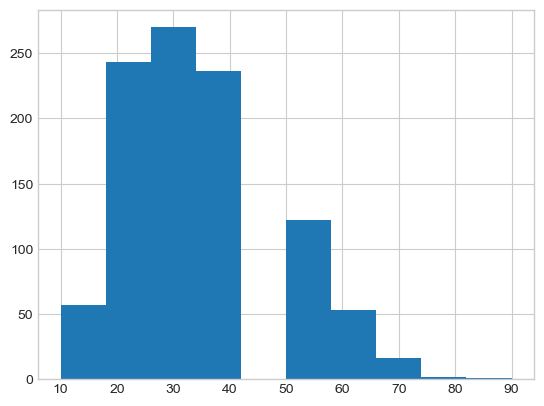

In [26]:
generalised_projection['age'].hist();

Achieving the optimal generalization for $k$-Anonymity is very challenging in cases like this. 

## Removing Outliers

Generalizing each row *more* would be overkill for the well-represented individuals with ages in the 20-40 range, and would hurt utility. 

However, more generalization is clearly needed for individuals at the upper and lower ends of the age range. 

This is the kind of challenge that occurs regularly in practice, and is difficult to solve automatically. 

In fact, **optimal generalization** for $k$-Anonymity has been shown to be NP-hard.

> **Challenge**:
>
>Outliers make achieving $k$-Anonymity very challenging, even for large datasets. Optimal generalization for $k$-Anonymity is NP-hard.

One solution to this problem is simply to **clip** the age of each individual in the dataset to lie within a specific range, eliminating outliers entirely.

This can also hurt utility, since it replaces real ages with fake ones, but it can be better than generalizing each row more.

We can use Numpy's `clip` method to perform this clipping. We clip ages to be `60` or below, and leave educational levels alone (by clipping them to a very large value).

In [27]:
# clipping away outliers
depths = {
    'age': 1,
    'edu': 1
}
projection_clipped = projection_age_edu.clip(upper=np.array([60, 10000000000000]), axis='columns')
generalised_projection_clipped = generalise(projection_clipped.head(500), depths)
is_k_anonymised(generalised_projection, 7)

False

## What if we add in the whole dataset ?

We can perform this generalization on all `32,000` rows:

In [28]:
is_k_anonymised(projection_age_edu, k=2)

False

In [29]:
depths = {
    'age': 1,
    'edu': 1
}
generalised_proj_whole_dataset = generalise(projection_age_edu, depths)
is_k_anonymised(generalised_proj_whole_dataset, k=2)

True

In [30]:
# the smallest group after generalisation
min(map(len, generalised_projection_clipped.groupby(generalised_projection_clipped.columns.tolist()).groups.values()))

7

In [31]:
min(map(len, generalised_proj_whole_dataset.groupby(generalised_proj_whole_dataset.columns.tolist()).groups.values()))

21

So in this case, adding more data increases the statistics, reaching a value of $k$ up to $21$!

## Summary

- $k$-Anonymity is a property of data, which ensures that each individual "blends in" with a group of at least $k$ individuals.
- $k$-Anonymity is computationally expensive even to check: the naive algorithm is $O(n^2)$, and faster algorithms take considerable space.
- $k$-Anonymity can be achieved by modifying a dataset by *generalizing* it, so that particular values become more common and groups are easier to form.
- Optimal generalization is extremely difficult, and outliers can make it even more challenging. Solving this problem automatically is NP-hard.

## Further Reading

- [Data Anonymization: Perspectives from a Former Skeptic](https://towardsdatascience.com/data-anonymization-perspectives-from-a-former-skeptic-f35790a2042a)
- `t-closeness` (**Beyond K-Anonimity**) [Paper](https://www.cs.purdue.edu/homes/ninghui/papers/t_closeness_icde07.pdf)
- _Anonymising and Sharing Individual Patients Data_ [Paper](https://www.bmj.com/content/bmj/350/bmj.h1139.full.pdf?casa_token=NwqT3F-i9xkAAAAA:U_T2t8ZaB1xWBgDOH7QbgQAuwMXJ6FehY07q_C0AztDejEDxp08awbjyWeOlMLOl14lV-W0z1OVjmw)